In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os 
os.chdir("/content/drive/My Drive/fast.ai v3/section 2/cust_dl_lib")

!git config --global user.email "rajp152000@gmail.com"
!git config --global user.name "rajp152k"
!pip install fire
import fire
datasets_path = "/content/drive/My Drive/fast.ai v3/datasets"

     |████████████████████████████████| 81kB 8.1MB/s 
  Created wheel for fire: filename=fire-0.2.1-py2.py3-none-any.whl size=103527 sha256=cca77c495988e335721610457856eee490237ca61959195085a842e73326436d
  Stored in directory: /root/.cache/pip/wheels/31/9c/c0/07b6dc7faf1844bb4688f46b569efe6cafaa2179c95db821da
Successfully built fire


In [3]:
!git pull

Already up to date.


In [0]:
from exps.nb_05a import *

# Conv Net

In [0]:
x_train,y_train,x_valid,y_valid = get_data()

normalizer

In [0]:
#export 
def normalize_to(train,valid):
    m,s = train.mean(),train.std()
    return normalize(train,m,s),normalize(valid,m,s)

In [0]:
x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train,y_train),Dataset(x_valid,y_valid)

In [0]:
def stats(x):
    x = x.float().unsqueeze(0)#dealing with vectors and integers
    return x.mean(),x.std()

In [9]:
stats(x_train),stats(x_valid)

((tensor(0.0001), tensor(1.)), (tensor(-0.0057), tensor(0.9924)))

In [10]:
stats(y_train),stats(y_valid)

((tensor(4.4488), tensor(2.8913)), (tensor(4.4794), tensor(2.8791)))

In [0]:
nh,bs = 50,512
c = y_train.max().item() + 1 # 10
loss_func  = F.cross_entropy

data = DataBunch(*get_dls(train_ds,valid_ds,bs),c)

creating a lambda layer: takes in a function and can use that as a layer in the network

In [0]:
#export 
class Lambda(nn.Module):
    def __init__(self,func):
        super().__init__()
        self.func = func
    def forward(self,x): return self.func(x)

def flatten(x): return x.view(x.shape[0],-1)

In [0]:
def mnist_resize(x): return x.view(-1,1,28,28)
# dataset's a vector

In [0]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d(1,8,5,padding=2,stride=2),nn.ReLU(), # 14
        nn.Conv2d(8,16,3,padding=1,stride=2),nn.ReLU(), # 7
        nn.Conv2d(16,32,3,padding=1,stride=2),nn.ReLU(), # 4
        nn.Conv2d(32,32,3,padding=1,stride=2),nn.ReLU(), # 2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32,data.c)
    )

In [0]:
model = get_cnn_model(data)

In [16]:
model

Sequential(
  (0): Lambda()
  (1): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (2): ReLU()
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): ReLU()
  (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (8): ReLU()
  (9): AdaptiveAvgPool2d(output_size=1)
  (10): Lambda()
  (11): Linear(in_features=32, out_features=10, bias=True)
)

basic callbacks

In [0]:
cbfs = [Recorder,partial(AvgStatsCallback,accuracy)]

In [0]:
opt = optim.SGD(model.parameters(),lr = 0.4)
learn = Learner(model,opt,loss_func,data)
run = Runner(cb_funcs = cbfs)

In [19]:
%time run.fit(1,learn)

train: [2.23916078125, tensor(0.1856)]
valid: [1.5825103515625, tensor(0.4669)]
CPU times: user 4.17 s, sys: 123 ms, total: 4.29 s
Wall time: 4.49 s


# shifting to Cuda

In [0]:
# use this method when using multiple GPUs
device = torch.device('cuda',0)

In [21]:
device

device(type='cuda', index=0)

In [0]:
# moves model and data to gpu after specific events
class CudaCallback(Callback):
    def __init__(self,device): self.device=device
    def begin_fit(self): self.model.to(self.device)
    # remember usage of getattr coded in the callback export
    # if not in current class, searches in the runner class
    def begin_batch(self): self.run.xb,self.run.yb=self.xb.cuda(),self.yb.cuda()

NOTE:


slightly more tedious cause then would have to look into the Runner class and see to that the \_\_init\_\_ of CudaCallback is given an argument: this can't be superficially as this is not a function and can't use the conventional partial here: try exploring the notion of partial classes and doing something like this later on:
```
cbfs.append(partial_class(CudaCallback,device))
```


EDIT:
CudaCallback actually represents the function \_\_init\_\_ of the class and hence partial works on it the same way it would work on a function
```
cbfs.append(partial(CudaCallback,device))
```
works (tested)

sticking to the defaults for now: eventhough less flexible

In [0]:
#export
class CudaCallback(Callback):
    def begin_fit(self):self.model.cuda()
    def begin_batch(self):
        self.run.xb = self.run.xb.cuda()
        self.run.yb = self.run.yb.cuda()

adding the shifting functionality to existing metrics callbacks: all that callback code paying off

In [0]:
cbfs = [Recorder,partial(AvgStatsCallback,accuracy)]
cbfs.append(CudaCallback)

In [0]:
# checking the speedup
model = get_cnn_model(data)

In [0]:
opt = optim.SGD(model.parameters(),lr = 0.4)
learn = Learner(model,opt,loss_func,data)
run = Runner(cb_funcs = cbfs)

In [27]:
%time run.fit(4,learn)

train: [1.97557734375, tensor(0.3002, device='cuda:0')]
valid: [0.61921044921875, tensor(0.8114, device='cuda:0')]
train: [0.37263640625, tensor(0.8839, device='cuda:0')]
valid: [0.1727135009765625, tensor(0.9506, device='cuda:0')]
train: [0.17242380859375, tensor(0.9479, device='cuda:0')]
valid: [0.130044677734375, tensor(0.9605, device='cuda:0')]
train: [0.125079755859375, tensor(0.9616, device='cuda:0')]
valid: [0.115139208984375, tensor(0.9669, device='cuda:0')]
CPU times: user 5.75 s, sys: 1.61 s, total: 7.35 s
Wall time: 13.4 s


speed up would increase with more depth and larger batch size 

# Refactoring model

lots of ReLU'ed Convs: combining

In [0]:
def conv2d(ni,nf,ks=3,stride=2):
    return nn.Sequential(nn.Conv2d(ni,nf,ks,padding = ks//2,stride=stride),
                         nn.ReLU())

resizing the mnist data in a batched way rather than in a go and using callbacks for that <br>
using a callback

In [0]:
#export 
class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self,tfm): self.tfm=tfm
    def begin_batch(self):self.run.xb = self.tfm(self.xb)

def view_tfm(*size):
    def _inner(x): return x.view(*((-1,)+size))
    return _inner

In [0]:
mnist_view = view_tfm(1,28,28)

In [0]:
cbfs.append(partial(BatchTransformXCallback,mnist_view))

In [0]:
nfs = [8,16,32,32]
# no of filters

In [0]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

creating a func to return a package of learner and runner so that there's no need to get them separately each time

In [0]:
def get_runner(model,data,lr=0.6,cbs=None,opt_func=None,loss_func=F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(),lr=lr)
    learn = Learner(model,opt,loss_func,data)
    return learn,Runner(cb_funcs=listify(cbs))

In [0]:
model = get_cnn_model(data,nfs)
learn,run = get_runner(model,data,lr=0.5,cbs=cbfs)

In [36]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [37]:
run.fit(5,learn)

train: [1.582929375, tensor(0.4715, device='cuda:0')]
valid: [0.429906982421875, tensor(0.8697, device='cuda:0')]
train: [0.3031022265625, tensor(0.9077, device='cuda:0')]
valid: [0.16741876220703125, tensor(0.9522, device='cuda:0')]
train: [0.16971443359375, tensor(0.9471, device='cuda:0')]
valid: [0.13148890380859374, tensor(0.9610, device='cuda:0')]
train: [0.125096025390625, tensor(0.9622, device='cuda:0')]
valid: [0.1041045166015625, tensor(0.9687, device='cuda:0')]
train: [0.1049324609375, tensor(0.9672, device='cuda:0')]
valid: [0.11148438720703124, tensor(0.9639, device='cuda:0')]


The main upgrade ..

# Hooks

for getting an idea of the purpose: say we manually store the statistics of some layers to observe the performance of initialization norms and their effect on activations

In [0]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.data.mean())
            self.act_stds [i].append(x.data.std ())
        return x
    
    def __iter__(self): return iter(self.layers)

In [0]:
model = SequentialModel(*get_cnn_layers(data,nfs))
learn,run = get_runner(model,data,lr=0.8,cbs = cbfs)

In [40]:
run.fit(3,learn)

train: [2.11994140625, tensor(0.2454, device='cuda:0')]
valid: [0.935844921875, tensor(0.7046, device='cuda:0')]
train: [0.5298415234375, tensor(0.8365, device='cuda:0')]
valid: [0.2001653564453125, tensor(0.9413, device='cuda:0')]
train: [0.2593514453125, tensor(0.9228, device='cuda:0')]
valid: [0.1711440185546875, tensor(0.9513, device='cuda:0')]


checking layer statistics now

In [41]:
model.layers

ModuleList(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

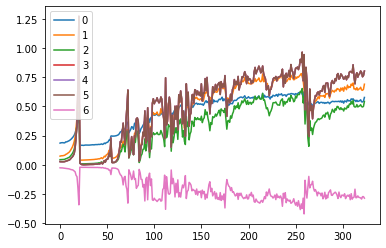

In [42]:
for l in model.act_means: plt.plot(l)
plt.legend(range(7))

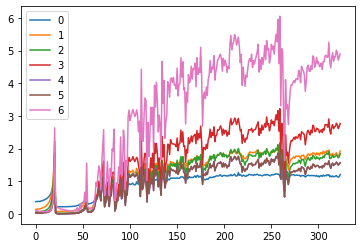

In [43]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(7))

yikes, spikes not good 

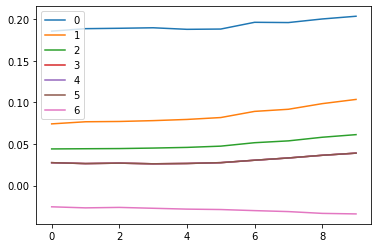

In [44]:
for l in model.act_means: plt.plot(l[:10])
plt.legend(range(7))

hmm

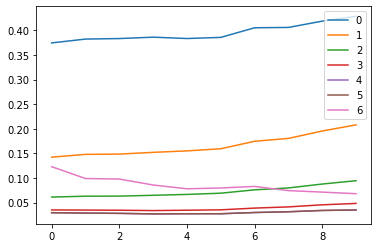

In [45]:
for l in model.act_stds:plt.plot(l[:10])
plt.legend(range(7))

the problem: exponetial decay of activations over several layers: should be close to 1: bad initialization

# Pytorch Hooks
working of pytorch hooks

In [0]:
model = get_cnn_model(data,nfs)
learn,run = get_runner(model,data,lr=0.5,cbs = cbfs)

In [0]:
act_means = [[] for _ in model]
act_stds = [[] for _ in model]

one hook corresponds to one layer and should have a function that takes in the following arguments:
 - module
 - input
 - output

the function then collects the necessary statistics for processing

In [0]:
def append_stats(i,mod,inp,outp):
    act_means[i].append(outp.data.mean())
    act_stds[i].append(outp.data.std())

In [0]:
for i,m in enumerate(model): 
    m.register_forward_hook(partial(append_stats,i))

Hence, hooks are, essentially, callbacks which are called when a certain process is completed. In the above case, we are registering a forward hook i.e. the passed function(append_stats) is called when we finish the forward pass of a specific layer

In [50]:
run.fit(1,learn)

train: [2.06380171875, tensor(0.2725, device='cuda:0')]
valid: [0.7371349609375, tensor(0.7768, device='cuda:0')]


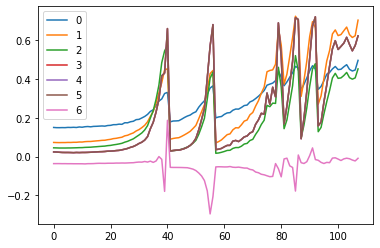

In [51]:
for o in act_means: plt.plot(o)
plt.legend(range(7))

In [0]:
act_means = [[] for l in model]
act_std = [[] for l in model]

In [0]:
for i,m in enumerate(model):
    m.register_forward_hook(partial(append_stats,i))

In [54]:
run.fit(3,learn)

train: [0.44018734375, tensor(0.8606, device='cuda:0')]
valid: [0.283982666015625, tensor(0.9076, device='cuda:0')]
train: [0.19933587890625, tensor(0.9396, device='cuda:0')]
valid: [0.12957196044921876, tensor(0.9609, device='cuda:0')]
train: [0.12409943359375, tensor(0.9626, device='cuda:0')]
valid: [0.09794133911132813, tensor(0.9701, device='cuda:0')]


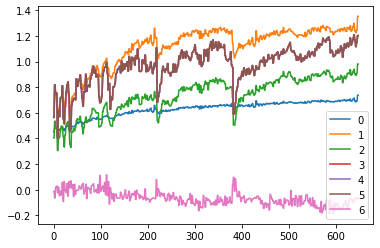

In [55]:
for o in act_means: plt.plot(o)
plt.legend(range(7));

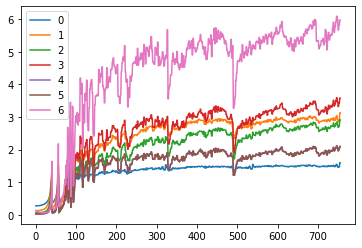

In [56]:
for o in act_stds:plt.plot(o)
plt.legend(range(7));

# refactoring before proceeding

note that deleting the hooks is important when not needed anymore: otherwise results in unfreed GPU memory

In [0]:
model.children??

In [0]:
#export
def children(m): return list(m.children())

class Hook():
    def __init__(self,m,f): 
        # model is the layer and f is the callback function
        self.hook = m.register_forward_hook(partial(f,self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

def append_stats(hook,module,inp,outp):
    if not hasattr(hook,'stats'):hook.stats = ([],[])
    means,stds = hook.stats
    means.append(outp.data.mean())
    stds.append(outp.data.std())

similar procedure for a backward pass: look into the documentation

In [0]:
model  = get_cnn_model(data,nfs)
learn,run = get_runner(model,data,lr=0.5,cbs = cbfs)

In [0]:
hooks = [Hook(l,append_stats) for l in children(model[:4])]

In [61]:
run.fit(1,learn)

train: [2.145485625, tensor(0.2376, device='cuda:0')]
valid: [1.012624609375, tensor(0.6580, device='cuda:0')]


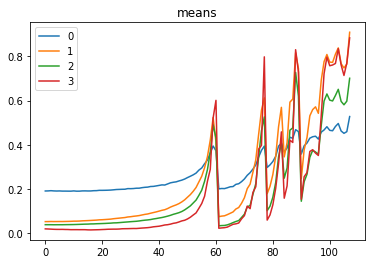

In [62]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(4))
plt.title("means");

# recreating a custom Hooks class

first creating a ListContainer as the parent class which will allow us to use numpy like indexing for the hooks

In [0]:
#export 
class ListContainer():
    def __init__(self,items):self.items=listify(items)
    def __getitem__(self,idx):
        if isinstance(idx,(int,slice)):return self.items[idx]
        if isinstance(idx[0],bool):
            assert(len(idx)==len(self))# boolean masking
            return [o for m,o in zip(idx,self.items) if m]
        return [self.items[i] for i in idx]
    def __len__(self):return len(self.items)
    def __iter__(self):return iter(self.items)
    def __setitem__(self,i,o): self.items[i] = o
    def __delitem__(self,i): del(self,items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)}items)\n{self.items[:10]}'
        if len(self)>10:res = res[:-1] +'...]'
        return res

In [71]:
ListContainer(range(5))

ListContainer (5items)
[0, 1, 2, 3, 4]

In [72]:
ListContainer(range(50))

ListContainer (50items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9...]

working ...

In [0]:
#export 
from torch.nn import init

class Hooks(ListContainer):
    def __init__(self,ms,f):super().__init__([Hook(m,f) for m in ms])
    def __enter__(self,*args): return self
    def __exit__(self,*args): self.remove()
    # dunder enter and exit allow the usage of "with"
    def __del__(self): self.remove()

    def __delitem(self,i):
        self[i].remove()
        # deleting then dereferencing
        super().__delitem__(i)

    def remove(self):
        for h in self: h.remove()


In [0]:
model = get_cnn_model(data,nfs)
learn,run = get_runner(model,data,lr=0.9,cbs=cbfs)

In [112]:
hooks = Hooks(model,append_stats)
for h in hooks:
    print(h)
print(len(hooks))

7


In [0]:
hooks.remove()

checking the working on a batch

In [0]:
x,y = next(iter(data.train_dl))
x = mnist_resize(x).cuda()

In [115]:
x.mean(),x.std()

(tensor(-0.0041, device='cuda:0'), tensor(0.9958, device='cuda:0'))

In [131]:
model.cuda()

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [117]:
model[0]

Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (1): ReLU()
)

testing on the first layer (conv'd relu)

In [118]:
p =  model[0](x)
p.mean(),p.std()

(tensor(0.2163, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.2976, device='cuda:0', grad_fn=<StdBackward0>))

expected results

In [0]:
for l in model:
    #initialising the right way
    if isinstance(l,nn.Sequential):
        init.kaiming_normal_(l[0].weight)#l[1] can be a ReLU
        l[0].bias.data.zero_()

In [120]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.5283, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.9222, device='cuda:0', grad_fn=<StdBackward0>))

the with statements allows for automatic cleanup after usage

train: [1.55475515625, tensor(0.4581, device='cuda:0')]
valid: [0.570867333984375, tensor(0.8195, device='cuda:0')]
train: [0.25881109375, tensor(0.9193, device='cuda:0')]
valid: [0.12939991455078126, tensor(0.9603, device='cuda:0')]


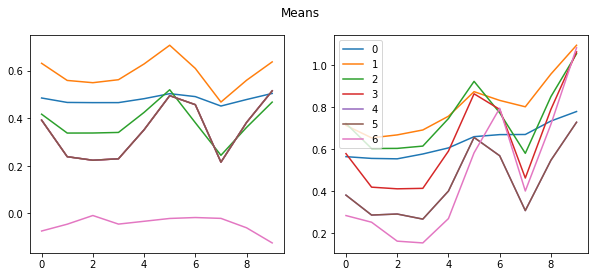

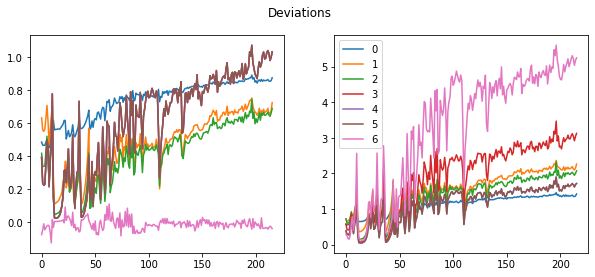

In [133]:
with Hooks(model,append_stats) as hooks:
    run.fit(2,learn)
    fig,(ax0,ax1) = plt.subplots(1,2,figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(7))
    fig.suptitle("Means");

    fig,(ax0,ax1) = plt.subplots(1,2,figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(7))
    fig.suptitle("Deviations");

# better now : no activation explosions/collapses

Storing more statistics:<br>
some histograms to get an idea of range of activation over an iteration and not just the mean and standard deviation

In [0]:
def append_stats(hook,mod,inp,outp):
    if not hasattr(hook,'stats'):hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds.append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,0,10))
    #histc not available for tensors on a GPU

In [0]:
model = get_cnn_model(data,nfs)
learn,run = get_runner(model,data,lr = 0.9,cbs=cbfs)

In [0]:
for l in model:
    if isinstance(l,nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [144]:
with Hooks(model,append_stats) as hooks:run.fit(1,learn)

train: [2.07564546875, tensor(0.2818, device='cuda:0')]
valid: [1.2797541015625, tensor(0.5444, device='cuda:0')]


In [151]:
hooks[0].stats[:2]
# means and stds of first conv'd relu
# last one is the history(not printing out)

([tensor(0.4921),
  tensor(0.4769),
  tensor(0.4930),
  tensor(0.5157),
  tensor(0.5479),
  tensor(0.4338),
  tensor(0.2788),
  tensor(0.2799),
  tensor(0.2858),
  tensor(0.2869),
  tensor(0.2909),
  tensor(0.3088),
  tensor(0.3188),
  tensor(0.3417),
  tensor(0.3582),
  tensor(0.3987),
  tensor(0.4223),
  tensor(0.3561),
  tensor(0.3551),
  tensor(0.3546),
  tensor(0.3557),
  tensor(0.3559),
  tensor(0.3589),
  tensor(0.3611),
  tensor(0.3715),
  tensor(0.3794),
  tensor(0.3957),
  tensor(0.4126),
  tensor(0.4328),
  tensor(0.4710),
  tensor(0.4815),
  tensor(0.4710),
  tensor(0.4174),
  tensor(0.4181),
  tensor(0.4457),
  tensor(0.4650),
  tensor(0.4629),
  tensor(0.4137),
  tensor(0.4460),
  tensor(0.4866),
  tensor(0.4598),
  tensor(0.4931),
  tensor(0.5455),
  tensor(0.4887),
  tensor(0.5887),
  tensor(0.5990),
  tensor(0.6117),
  tensor(0.6244),
  tensor(0.6379),
  tensor(0.6715),
  tensor(0.5788),
  tensor(0.5946),
  tensor(0.6180),
  tensor(0.5922),
  tensor(0.6122),
  tensor(0

In [0]:
def get_hist(h):
    return torch.stack(h.stats[2]).t().float().log1p()
# look into documentation for unknown procedures

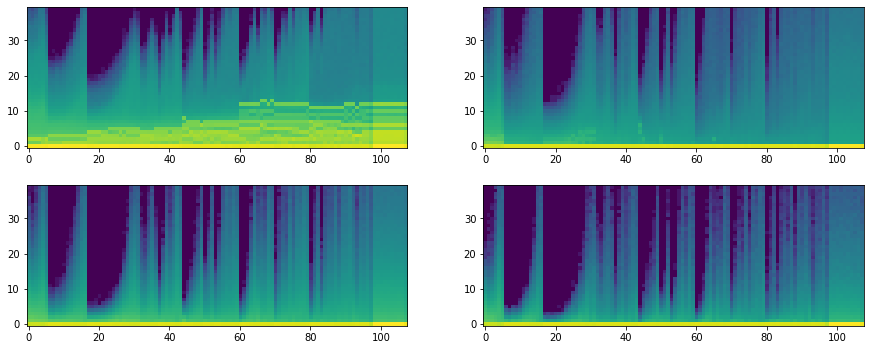

In [163]:
fig,axes = plt.subplots(2,2,figsize=(15,6))
for ax,h in zip(axes.flatten(),hooks[:4]):
    ax.imshow(get_hist(h),origin='lower')
    #origin='lower' helps treat the image as a graph
    #if removed, we'll get an origin in the top-left
    
    #ax.axis('off') 
    # uncomment the above 
    # in case of quantitative analysis not being useful


lots of collapses: not good<br>
this did not show in the plots for means and stds() clearly
creating a Generalized Relu shortly for maintenance of healthier statistics over time

first grabbing the minimums and maximum of the activations

In [0]:
h_list = hooks[0].stats[2]
# grabbing the hists for the first layer
# for some shape tests

In [186]:
len(h_list) # no of iterations

108

In [182]:
h_list[0].shape 
# no. of bins over one iteration for 
# recording the activations

torch.Size([40])

In [0]:
torch.stack??

In [0]:
h_stacked = torch.stack(h_list,dim=1)

In [198]:
h_stacked.shape

torch.Size([40, 108])

In [0]:
h_stacked = h_stacked.t().float()

In [207]:
h_stacked[:2].shape

torch.Size([2, 40])

In [208]:
h_stacked[:2].sum(0).shape
# stores the implicit mean frequency (over 2 iterations) 
# corresponding to the 40 bins

torch.Size([40])

In [209]:
h_stacked.sum(0).shape
# does the same (over time) for all the iterations

torch.Size([40])

stacking the ones in the list to create a 
manipulable tensor

In [0]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[:2].sum(0)/h1.sum(0) 

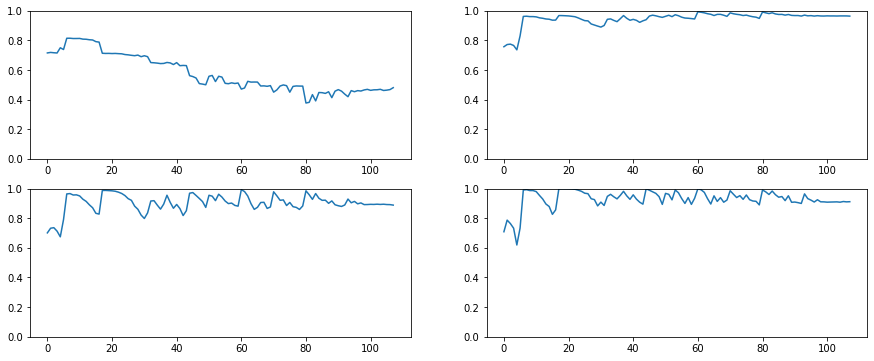

In [211]:
fig,axes = plt.subplots(2,2,figsize=(15,6))
for ax,h in zip(axes.flatten(),hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
    

# Generalized ReLU
can be tweaked with max clamps, leaks and other modifications

In [0]:
#export 
def get_cnn_layers(data, nfs, layer, **kwargs):
    nfs = [1] + nfs
    return [layer(nfs[i], nfs[i+1], 5 if i==0 else 3, **kwargs)
            for i in range(len(nfs)-1)] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]
    # i for Conv and i+1 for ReLU

def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), GeneralRelu(**kwargs))


class GeneralRelu(nn.Module):
    def __init__(self,leak=None,sub=None,maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv
    
    def forward(self,x):
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

def init_cnn(m,uniform=False):
    # look into opportunity costs for uniform initialisation 
    # instead of normal (Gaussian) initialisation
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in m:
        if isinstance(l,nn.Sequential):
            f(l[0].weight,a=0.1)
            l[0].bias.data.zero_()

def get_cnn_model(data,nfs,layer,**kwargs):
    return nn.Sequential(*get_cnn_layers(data,nfs,layer,**kwargs))


In [0]:
def append_stats(hook,mod,inp,outp):
    if not hasattr(hook,'stats'):hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds.append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,-7,7))

In [0]:
model = get_cnn_model(data,nfs,conv_layer,leak=0.1,sub=0.4,maxv=6.)
init_cnn(model)
learn,run = get_runner(model,data,lr=0.9,cbs = cbfs)

train: [0.53635140625, tensor(0.8285, device='cuda:0')]
valid: [0.1402550048828125, tensor(0.9574, device='cuda:0')]


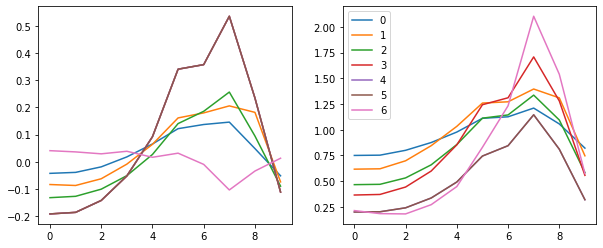

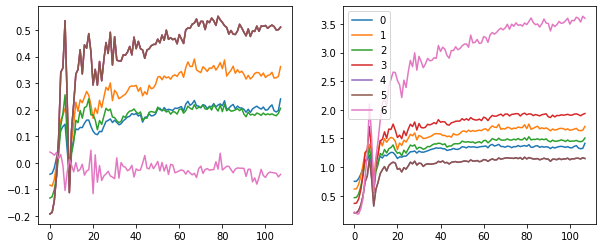

In [243]:
with Hooks(model,append_stats) as hooks:
    run.fit(1,learn)
    fig,(ax0,ax1) = plt.subplots(1,2,figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(7));

    fig,(ax0,ax1) = plt.subplots(1,2,figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
        h.remove()
    plt.legend(range(7));

    

this is good : deviations do converge(somewhat)

plotting histograms

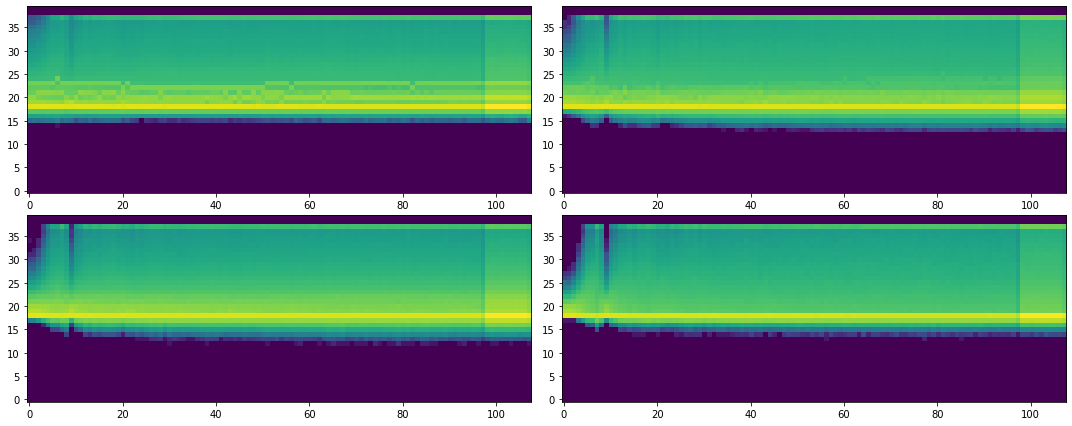

In [244]:
fig,axes = plt.subplots(2,2,figsize=(15,6))
for ax,h in zip(axes.flatten(),hooks[:4]):
    ax.imshow(get_hist(h),origin='lower')
plt.tight_layout()

much better activations: no collapses : model'll converge faster

plotting mins

In [0]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[19:22].sum(0)/h1.sum(0)

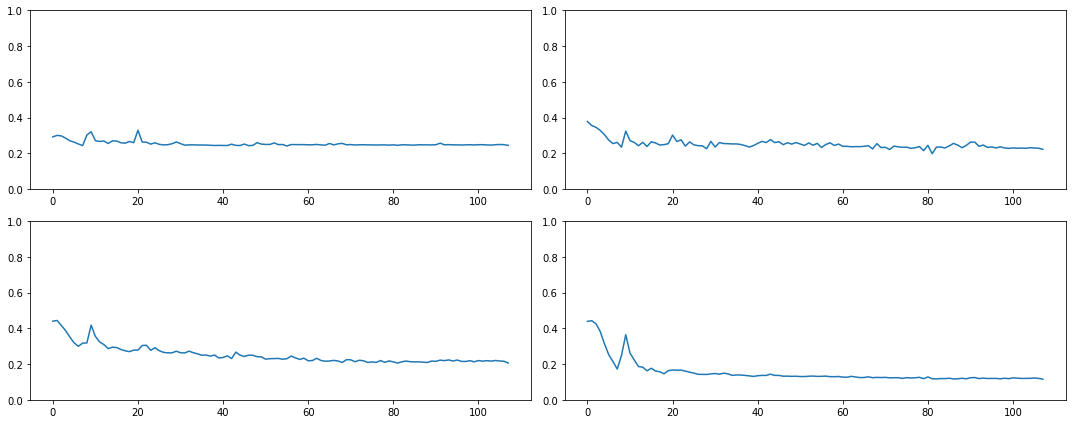

In [246]:
fig,axes = plt.subplots(2,2,figsize=((15,6)))
for ax,h in zip(axes.flatten(),hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

# Refactoring and testing all the new functionality

In [0]:
#export 
def get_learn_run(nfs,data,lr,layer,cbs=None,opt_func=None,uniform=False,**kwargs):
    model = get_cnn_model(data,nfs,layer,**kwargs)
    init_cnn(model,uniform=uniform)
    return get_runner(model,data,lr=lr,cbs=cbs,opt_func=opt_func)

In [0]:
sched = combine_scheds([0.5,0.5],(sched_cos(0.2,1.),sched_cos(1.,0.1)))
cbfs.append(partial(ParamScheduler,'lr',sched))

In [0]:
learn,run = get_learn_run(nfs,data,1.,conv_layer,cbs = cbfs)

In [254]:
run.fit(10,learn)

train: [1.6592165625, tensor(0.4453, device='cuda:0')]
valid: [0.492998486328125, tensor(0.8495, device='cuda:0')]
train: [0.3385201953125, tensor(0.8986, device='cuda:0')]
valid: [0.1967278564453125, tensor(0.9421, device='cuda:0')]
train: [0.535919765625, tensor(0.8406, device='cuda:0')]
valid: [0.19136182861328124, tensor(0.9416, device='cuda:0')]
train: [0.15262267578125, tensor(0.9537, device='cuda:0')]
valid: [0.2114445556640625, tensor(0.9398, device='cuda:0')]
train: [0.1056964453125, tensor(0.9677, device='cuda:0')]
valid: [0.1008985595703125, tensor(0.9701, device='cuda:0')]
train: [0.090006572265625, tensor(0.9715, device='cuda:0')]
valid: [0.08779193115234375, tensor(0.9776, device='cuda:0')]
train: [0.0688452490234375, tensor(0.9787, device='cuda:0')]
valid: [0.13073641357421875, tensor(0.9629, device='cuda:0')]
train: [0.0635320849609375, tensor(0.9798, device='cuda:0')]
valid: [0.08964635620117188, tensor(0.9732, device='cuda:0')]
train: [0.0527494677734375, tensor(0.983

checking with a uniform init

In [0]:
learn,run = get_learn_run(nfs,data,1.,conv_layer,uniform=True,cbs=cbfs)

In [258]:
run.fit(10,learn)

train: [2.25523234375, tensor(0.1773, device='cuda:0')]
valid: [1.64847578125, tensor(0.4112, device='cuda:0')]
train: [1.0351675, tensor(0.6491, device='cuda:0')]
valid: [0.2989674072265625, tensor(0.9021, device='cuda:0')]
train: [0.30247451171875, tensor(0.9048, device='cuda:0')]
valid: [0.21466064453125, tensor(0.9317, device='cuda:0')]
train: [0.18094359375, tensor(0.9430, device='cuda:0')]
valid: [0.13793441162109374, tensor(0.9560, device='cuda:0')]
train: [0.12095818359375, tensor(0.9627, device='cuda:0')]
valid: [0.114218359375, tensor(0.9637, device='cuda:0')]
train: [0.097302021484375, tensor(0.9697, device='cuda:0')]
valid: [0.095203857421875, tensor(0.9702, device='cuda:0')]
train: [0.084656396484375, tensor(0.9726, device='cuda:0')]
valid: [0.09051027221679687, tensor(0.9729, device='cuda:0')]
train: [0.0737962060546875, tensor(0.9767, device='cuda:0')]
valid: [0.07760509643554687, tensor(0.9771, device='cuda:0')]
train: [0.06733958984375, tensor(0.9781, device='cuda:0')]

similar results: both hold value: look further into these 

# Exporting

In [259]:
!python3 notebook2script.py 06_hooks.ipynb

Converted 06_hooks.ipynb to exps/nb_06.py


In [0]:
!git add .
!git commit -m "added ability to hook onto activations mid-training"